# Create multiclass classification model with Pytorch

## Imports

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timeit import default_timer as timer 

plt.style.use('dark_background')

## Create DataLoader and necessary structures

### Create transform to tensor

In [2]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5 , .5, .5))
])

### Create Datasets

In [3]:
train_set = torchvision.datasets.CIFAR10(root='data', 
                                         train=True, 
                                         download=True, 
                                         transform = transform)
test_set = torchvision.datasets.CIFAR10(root='data', 
                                         train=False, 
                                         download=True, 
                                         transform = transform)

Files already downloaded and verified
Files already downloaded and verified


### Create DataLoader and classes

In [4]:
BATCH_SIZE = 4
train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)
test_loader = DataLoader(dataset=test_set,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=2)

In [5]:
classes = train_set.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Create visualize function

In [6]:
def imshow(img):
    img = img/2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.gcf().patch.set_alpha(0.0)
    plt.subplot(111).patch.set_alpha(0.0)
    plt.grid(False)
    plt.show()

In [7]:
images, labels = next(iter(train_loader))

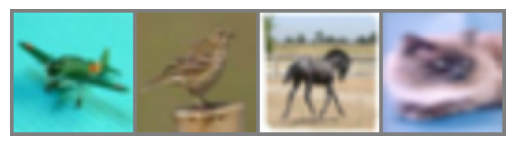

airplane bird  horse cat  


In [8]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[i]]:5s}' for i in range(BATCH_SIZE)))

## Create and train model 

### Create class Net

In [209]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 10)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)
        return output


In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Train model_Net

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
model_Net = Net().to(device)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_Net.parameters(), lr=0.001, weight_decay=0.0001, amsgrad=True)

In [13]:
def testAccuracy():
    model_Net.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model_Net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels.to(device)).sum().item()
    accuracy = (100 * accuracy / total)
    return(accuracy)

In [14]:
epochs = 10
start_time = timer()
for epoch in tqdm(range(epochs)):
    epoch_loss = .0
    epoch_acc = .0
    for batch, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        pred = model_Net(inputs)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_acc = testAccuracy()
    print(f'Epoch: {epoch + 1} | loss: {epoch_loss / 20000:.3f} Accuracy: {epoch_acc:.3f}')
            
end_time = timer()
print('Finished Training ')
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | loss: 0.926 Accuracy: 53.460
Epoch: 2 | loss: 0.746 Accuracy: 60.080
Epoch: 3 | loss: 0.661 Accuracy: 59.880
Epoch: 4 | loss: 0.601 Accuracy: 59.960
Epoch: 5 | loss: 0.555 Accuracy: 62.290
Epoch: 6 | loss: 0.514 Accuracy: 62.690
Epoch: 7 | loss: 0.477 Accuracy: 62.300
Epoch: 8 | loss: 0.444 Accuracy: 62.930
Epoch: 9 | loss: 0.415 Accuracy: 61.690
Epoch: 10 | loss: 0.385 Accuracy: 60.990
Finished Training 
Total training time: 754.815 seconds


In [12]:
PATH = 'models/cifar_net_1_new_amsgrad .pth'
#torch.save(model_Net.state_dict(), PATH)

### Make pred

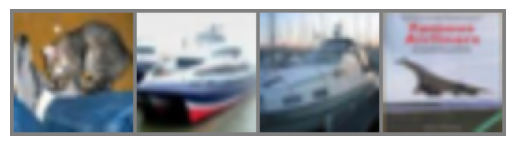

GroundTruth:  cat   ship  ship  airplane


In [13]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [16]:
pred = net(images)
_, predicted = torch.max(pred, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))
pred

Predicted:  ship  ship  ship  airplane


tensor([[ -0.7823,  -3.9022,  -0.6766,   1.5903,  -3.5352,   0.1642,  -0.5863,
          -1.1156,   3.2784,  -0.1791],
        [  3.7926,   2.1324,  -7.1703,  -8.0804,  -9.5567,  -9.7128, -10.7707,
          -6.8624,   4.6249,   3.4165],
        [  1.9610,   0.1857,  -2.5338,  -1.6414,  -5.1659,  -4.0226,  -4.2833,
          -2.7765,   2.0009,  -0.8365],
        [  5.6149,  -2.0290,  -3.4927,  -5.7933,  -3.9075,  -7.8624,  -6.5619,
          -4.6023,   3.5454,  -1.1470]], grad_fn=<AddmmBackward0>)

In [19]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 65.8 %
Accuracy for class: automobile is 78.6 %
Accuracy for class: bird  is 59.2 %
Accuracy for class: cat   is 44.5 %
Accuracy for class: deer  is 45.3 %
Accuracy for class: dog   is 42.3 %
Accuracy for class: frog  is 80.0 %
Accuracy for class: horse is 57.0 %
Accuracy for class: ship  is 69.9 %
Accuracy for class: truck is 67.3 %


## Test with my data

In [21]:
import os
import random
from PIL import Image
from pathlib import Path

In [22]:
my_data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5 , .5, .5))
])

In [23]:
def make_preds(imgs_path,
               model,
               transform,
               classes,
               only_err= True,
               path= None,):
    if path:
        imgs_path_list = list(imgs_path.glob(f'{path}/*.jpg'))
    else:
        imgs_path_list = list(imgs_path.glob(f'*/*.jpg'))
    for img_path in imgs_path_list:
        with Image.open(img_path) as f:
            img_t = transform(f)
        pred = torch.argmax(model(img_t.unsqueeze(0)))
        img_t_permute = img_t.permute(1,2,0)
        color = 'green' if classes[pred] == img_path.parent.stem else 'red'
        if only_err and classes[pred] == img_path.parent.stem:
            continue
        plt.imshow(img_t_permute)
        plt.title(f'Pred: {classes[pred]}\n Real: {img_path.parent.stem}', color= color)
        plt.axis(False)
        plt.gcf().patch.set_alpha(0.0)
        plt.subplot(111).patch.set_alpha(0.0)
        plt.grid(False)
        plt.show()

In [24]:
my_imgs_path = Path('data/cifar-10-batches-py/my_img')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


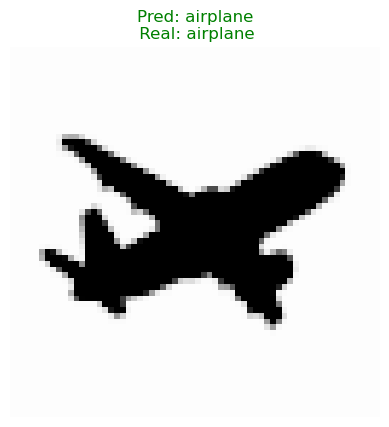

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


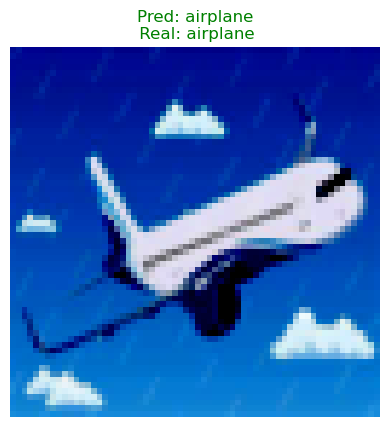

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


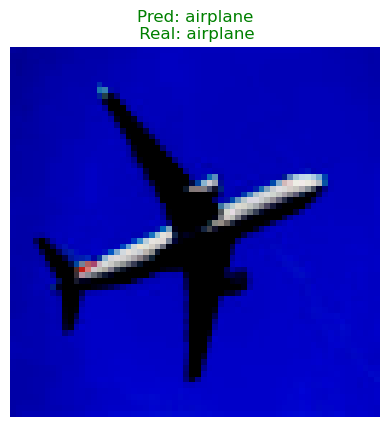

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


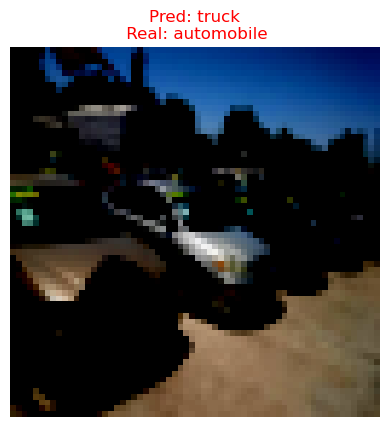

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


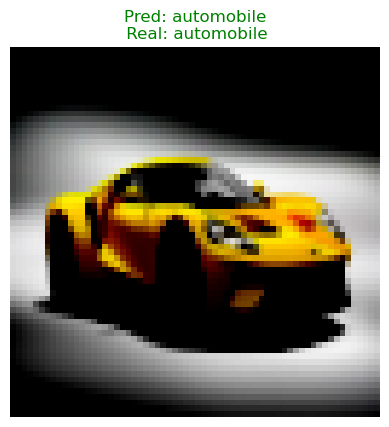

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


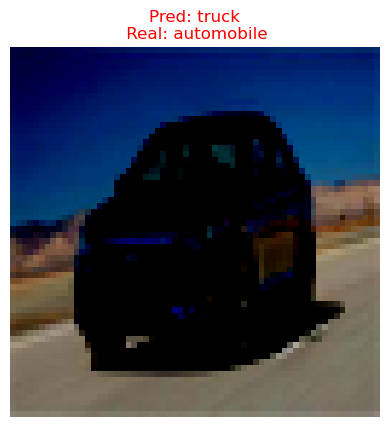

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


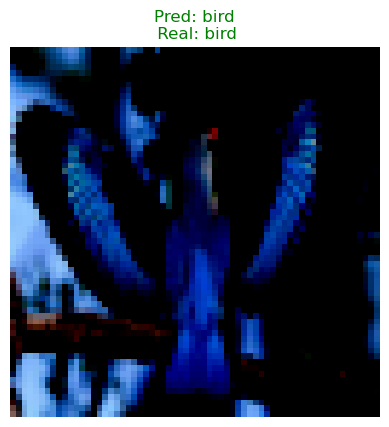

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


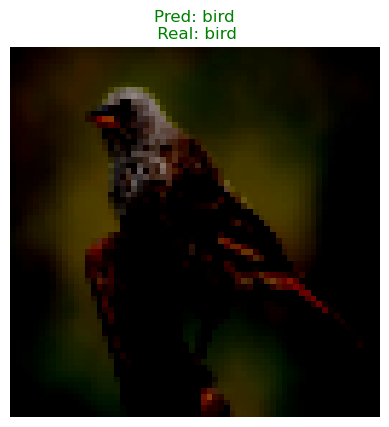

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


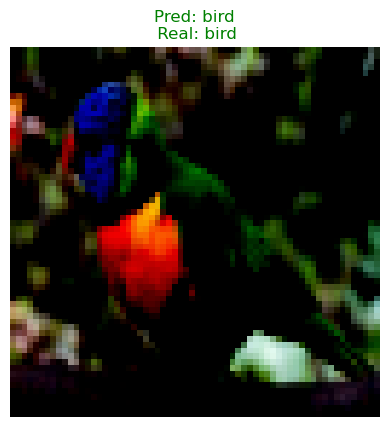

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


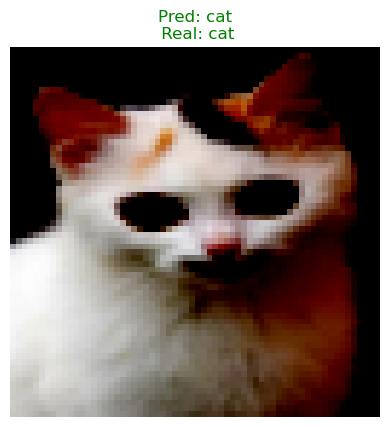

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


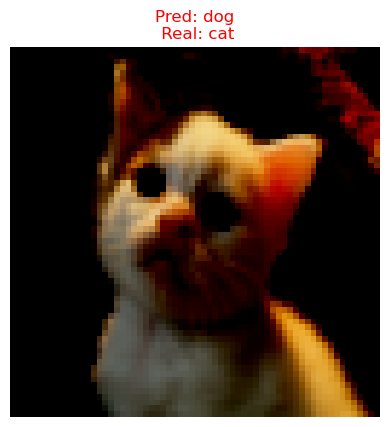

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


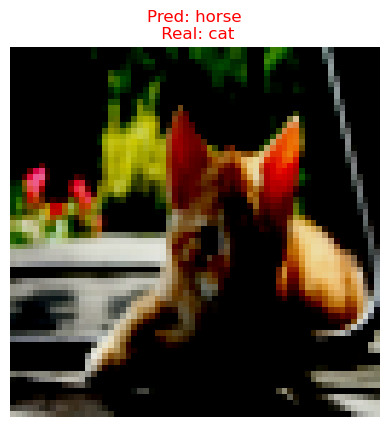

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


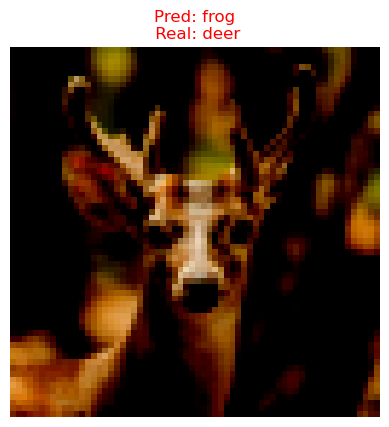

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


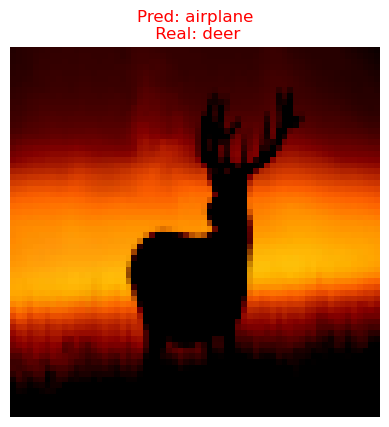

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


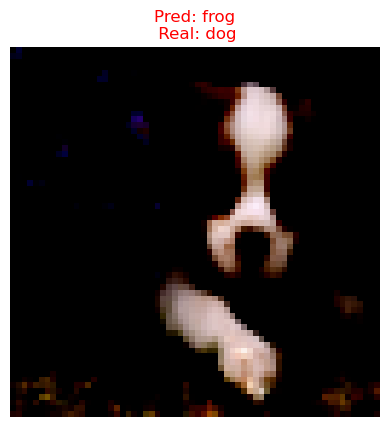

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


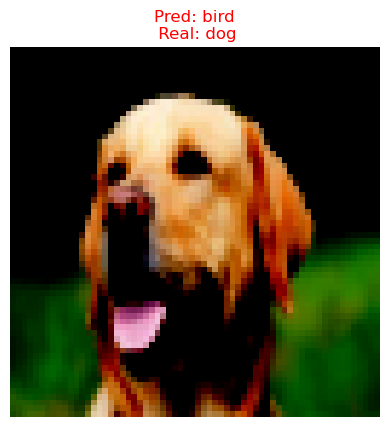

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


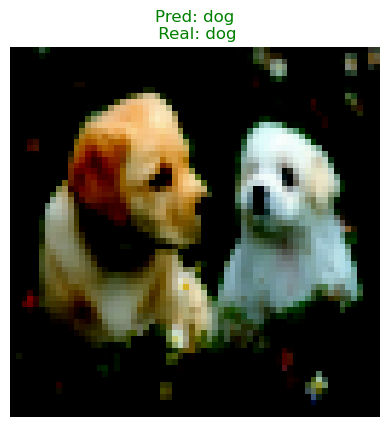

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


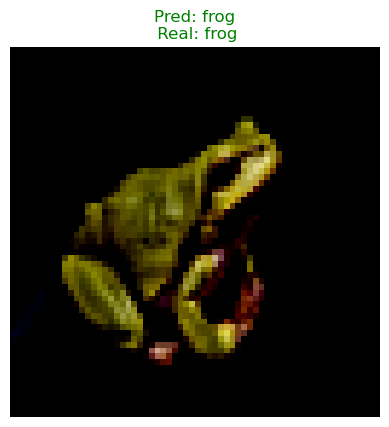

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


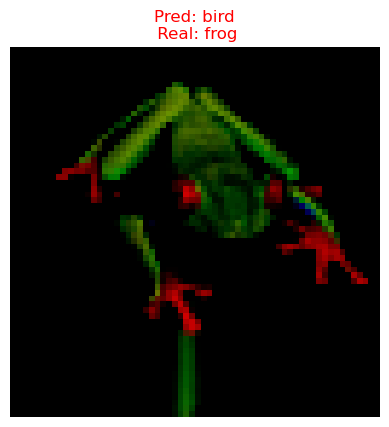

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


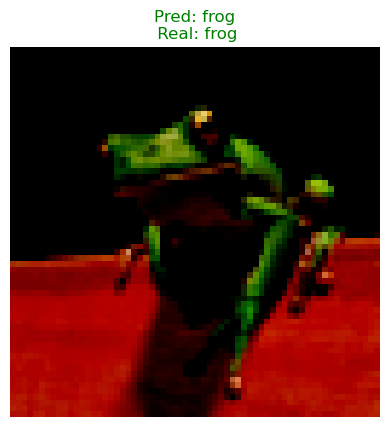

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


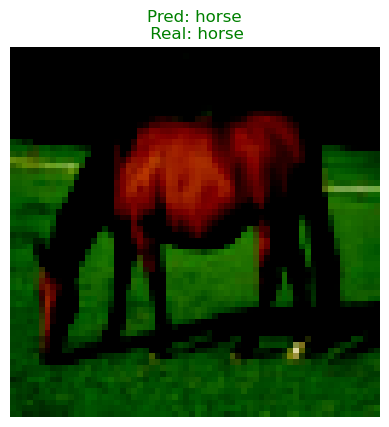

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


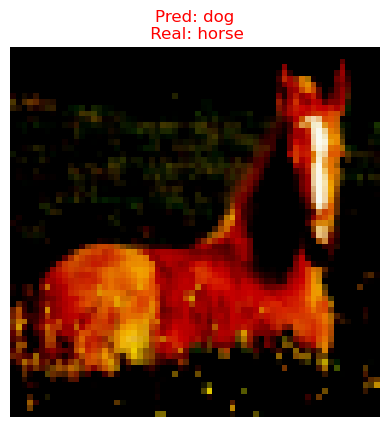

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


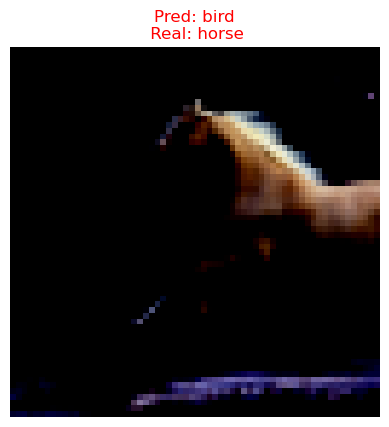

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


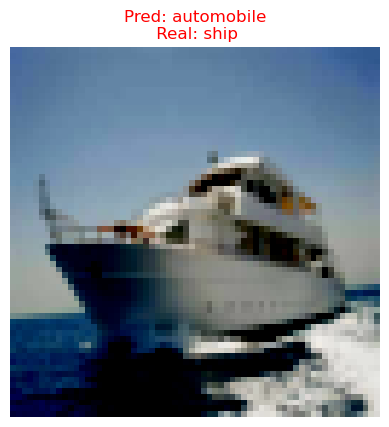

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


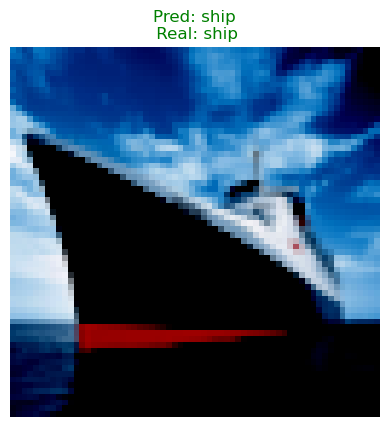

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


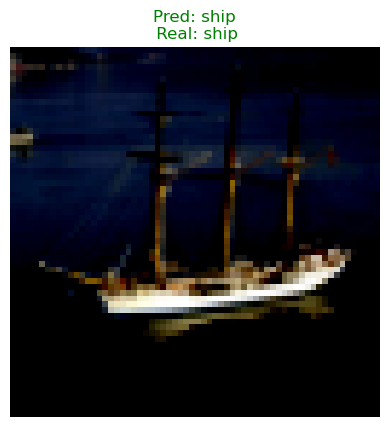

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


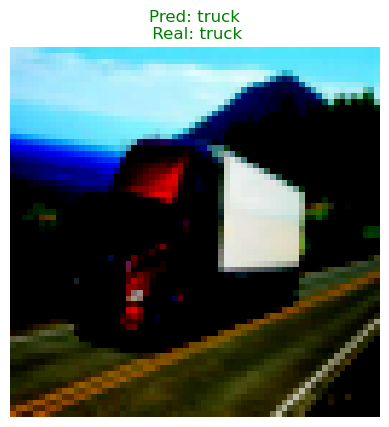

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


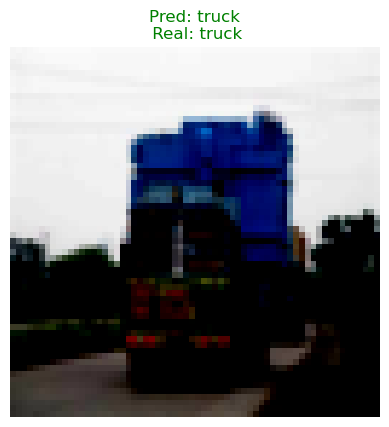

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


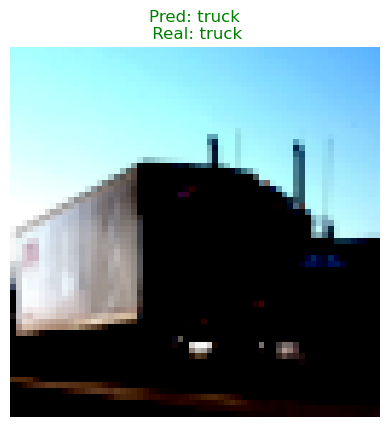

In [25]:
make_preds(imgs_path=my_imgs_path,
              model=net,
              transform=my_data_transform,
              classes=classes,
              only_err=False);

cifar_net_1_new
